# Final Results
### This notebook is the cumlination of my results

## First problem:
### Imitation learning with no adversarial data
#### Using openai-gym enviroments of classical controll problems
#### Enviroments: CartPole-v0, MountainCar-v0, Acrobat-v1

In [1]:
import gym
import numpy as np
import pickle
from experts import Expert

import warnings
warnings.filterwarnings('ignore')

car = gym.make('MountainCar-v0')
cart = gym.make('CartPole-v0')
acrobot = gym.make('Acrobot-v1')

car_expert = Expert('MountainCar-v0')
cart_expert = Expert('CartPole-v0')
acrobot_expert = Expert('Acrobot-v1')

In [2]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [3]:
def t_tests(data, equal_var=False):
    
    for column in data.columns:
        if column != 'expert' and column != 'random':
            print('T test for epxert vs {}: {}'.format(column, scipy.stats.ttest_ind(a=data[column], b=data['expert'], equal_var=equal_var)))
            print('T test for random vs {}: {}'.format(column, scipy.stats.ttest_ind(a=data[column], b=data['random'], equal_var=equal_var)))

### Mountain Car

In [4]:
import pandas as pd
Rewards = pd.DataFrame()
ACC = pd.DataFrame()

data, rewards, splits = car_expert.generate_data(20)
ACC['expert'] = np.array([1 for i in range(20)])
Rewards['expert'] = rewards
data, rewards, splits = car_expert.generate_data(20, adversary='random')
ACC['random'] = np.array([1 for i in range(20)])
Rewards['random'] = rewards

#### Linear Chain CRF
##### Implmented using sklearn-CRFSuite

In [23]:
def feats(seq, k):
    
    return {
            'position': np.format_float_positional(seq[k-1][0], 2, unique=False),
            'velocity': np.format_float_positional(seq[k-1][1], 3, unique=False),
            'position1': np.format_float_positional(seq[k][0], 2, unique=False),
            'velocity1': np.format_float_positional(seq[k][1], 3, unique=False),
            'first': k == 0,
            'last': k == len(seq)-1,
            'bias': True
    }

def labs(seq, k):
    
    return str(seq[k][2])
    
def seq_to_feats(seq):
    
    return [feats(seq, k) for k in range(len(seq))]

def seq_to_labs(seq):
    
    return [labs(seq, k) for k in range(len(seq))]

crf = pickle.load(open('crf_models/non_adversarial/mountain_car.pkl', 'rb'))


rewards = []

for j in range(20):
    sequence = np.empty((201, 2))
    sequence[0] = car.reset()
    i = 0
    done = False
    score = 0
    while not done:
        
        i += 1
        features = seq_to_feats(sequence[0:i])
        #print(features)
        policy = int(float(crf.predict_single(features)[-1]))
        observation, reward, done, info = car.step(policy)
        sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
       
        
    
    rewards.append(score)
    
data, rewards, splits = car_expert.generate_data(20)
X = [seq_to_feats(seq) for seq in np.split(data, splits)[0:-1]]
y = [seq_to_labs(seq) for seq in np.split(data, splits)[0:-1]]
preds = crf.predict(X)
acc = np.array([np.mean(np.array(pred) == np.array(act)) for pred, act in zip(preds, y)])

In [26]:
crf.num_attributes_

487

In [6]:
rewards

array([-104.,  -89., -104.,  -89., -103., -130., -102., -104., -115.,
        -86., -104.,  -89., -133.,  -84., -102.,  -86., -104., -104.,
        -99.,  -88.])

In [7]:
Rewards['crf'] = rewards
ACC['crf'] = acc

#### Bi-Directional LSTM
##### Implemnted using PyTorch

In [8]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, target_size):
        
        super(PolicyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, bias=True, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim*2, target_size)
        self.output = nn.LogSoftmax(dim=2)
        
    def forward(self, batch):
        
        lstm_out, _ = self.lstm(batch)
        linear_out = self.linear(lstm_out)
        out = self.output(linear_out)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)

        return torch.argmax(pred, dim=2).view(-1)

lstm = PolicyLSTM(4, 10, 3)

In [18]:
lstm.load_state_dict(torch.load('lstm_models/non_adversarial/mountain_car.pt'), strict=False)
x = 0
for param in lstm.parameters():
    x += np.product([p for p in param.shape])
    
x, 100**2 *100 / 2

(1343, 500000.0)

In [10]:
def seq_to_x(seq):
    
    return torch.tensor([
            [seq[i][0], seq[i][1],  int(i==0), 0] 
            for i in range(len(seq))
        ], dtype=torch.float).unsqueeze(0)

def seq_to_target(seq):
    
    return torch.tensor([
            seq[i][2] for i in range(len(seq))
        ], dtype=torch.long)


def test_X(data):
    
    return [
                seq_to_x(seq) for seq in data
            ]


def test_Y(data):
    
    return [
            seq_to_target(seq) for seq in data
        ]

rewards = []
for i in range(20):

    #print(i)
    observation = car.reset()
    done = False
    rd = 0
    traj = torch.tensor([[99, 99, 0, 1] for i in range(200)], dtype=torch.float).unsqueeze(0)
    while not done:

        traj[0][-rd] = torch.tensor([ob for ob in observation] + [int(rd==0)] + [0])
        action = lstm.predict(traj)
        #print(action, expert.policy(observation), -rd)
        observation, reward, done, _ = car.step(int(action[-rd].item()))
        rd += int(reward)

    rewards.append(rd)

data, rewards, splits = car_expert.generate_data(20)
X = test_X(np.split(data, splits)[0:-1])
y = test_Y(np.split(data, splits)[0:-1])
preds = [lstm.predict(x) for x in X]
acc = np.array([np.mean(np.array(pred) == np.array(act)) for pred, act in zip(preds, y)])

In [11]:
Rewards['lstm'] = rewards
ACC['lstm'] = acc

#### GAIL

In [12]:
import pickle


gail_acc_20 = pickle.load(open('gail_mountain_car_acc_20.pkl', 'rb'))
gail_rewards_20 = pickle.load(open('gail_mountain_car_rewards_20.pkl', 'rb'))

Rewards['gail'] = gail_rewards_20
ACC['gail'] = gail_acc_20


Bad key "text.kerning_factor" on line 4 in
/home/brendanjcrowe/anaconda3/envs/seq/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


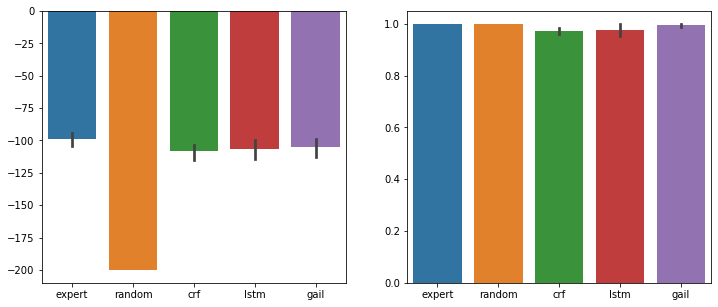

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.barplot(data=Rewards, ax=ax[0])
sns.barplot(data=ACC, ax=ax[1])

In [14]:
result = pd.DataFrame()
for column in ACC.columns:
    print('Confidence Interval for the mean accuracy of {}: {}'.format(column, mean_confidence_interval(ACC[column].to_numpy())))
    print('Confidence Interval for the mean reward of {}: {}'.format(column, mean_confidence_interval(Rewards[column].to_numpy())))

Confidence Interval for the mean accuracy of expert: (1.0, 0.0)
Confidence Interval for the mean reward of expert: (-99.0, 5.918018330600604)
Confidence Interval for the mean accuracy of random: (1.0, 0.0)
Confidence Interval for the mean reward of random: (-200.0, 0.0)
Confidence Interval for the mean accuracy of crf: (0.9743920230920015, 0.013448717854859262)
Confidence Interval for the mean reward of crf: (-108.5, 6.469869870337028)
Confidence Interval for the mean accuracy of lstm: (0.9779365079365079, 0.02526377013663165)
Confidence Interval for the mean reward of lstm: (-106.7, 7.781315937630421)
Confidence Interval for the mean accuracy of gail: (0.9946173615077099, 0.004624463584423555)
Confidence Interval for the mean reward of gail: (-105.25, 7.72746098065284)


In [15]:
t_tests(ACC)


T test for epxert vs crf: Ttest_indResult(statistic=-3.9853696264292084, pvalue=0.0007922310986608718)
T test for random vs crf: Ttest_indResult(statistic=-3.9853696264292084, pvalue=0.0007922310986608718)
T test for epxert vs lstm: Ttest_indResult(statistic=-1.8278910615235586, pvalue=0.08331323022135807)
T test for random vs lstm: Ttest_indResult(statistic=-1.8278910615235586, pvalue=0.08331323022135807)
T test for epxert vs gail: Ttest_indResult(statistic=-2.4361726792473863, pvalue=0.024857637286018017)
T test for random vs gail: Ttest_indResult(statistic=-2.4361726792473863, pvalue=0.024857637286018017)


In [16]:
t_tests(Rewards)

T test for epxert vs crf: Ttest_indResult(statistic=-2.2676971011248708, pvalue=0.029164656345609993)
T test for random vs crf: Ttest_indResult(statistic=29.60054913258709, pvalue=2.3228199855619726e-17)
T test for epxert vs lstm: Ttest_indResult(statistic=-1.6485420126318067, pvalue=0.10807246928338751)
T test for random vs lstm: Ttest_indResult(statistic=25.09590226659755, pvalue=4.963207618352339e-16)
T test for epxert vs gail: Ttest_indResult(statistic=-1.343987882591969, pvalue=0.18745951328430543)
T test for random vs gail: Ttest_indResult(statistic=25.66354325847773, pvalue=3.282751855765614e-16)


### Cart Pole

In [17]:
Rewards = pd.DataFrame()
ACC = pd.DataFrame()

data, rewards, splits = cart_expert.generate_data(20)
ACC['expert'] = np.array([1 for i in range(20)])
Rewards['expert'] = rewards
data, rewards, splits = cart_expert.generate_data(20, adversary='random')
ACC['random'] = np.array([1 for i in range(20)])
Rewards['random'] = rewards

#### CRF

In [18]:
def feats(seq, k):
    
    return {
            'f11': np.format_float_positional(seq[k-1][0], 1, unique=False),
            'f12': np.format_float_positional(seq[k][0], 1, unique=False),
            'f21': np.format_float_positional(seq[k-1][1], 2, unique=False),
            'f22': np.format_float_positional(seq[k][1], 2, unique=False),
            'f31': np.format_float_positional(seq[k-1][2], 2, unique=False),
            'f32': np.format_float_positional(seq[k][2], 2, unique=False),
            'f41': np.format_float_positional(seq[k-1][3], 2, unique=False),
            'f42': np.format_float_positional(seq[k][3], 2, unique=False),
            'first': k == 0,
            #'last': k == len(seq)-1
            #'bias': True
    }

def labs(seq, k):
    
    return str(seq[k][4])
    
def seq_to_feats(seq):
    
    return [feats(seq, k) for k in range(len(seq))]

def seq_to_labs(seq):
    
    return [labs(seq, k) for k in range(len(seq))]

crf = pickle.load(open('crf_models/non_adversarial/cart_pole.pkl', 'rb'))

rewards = []

for j in range(20):
    sequence = np.empty((201, 4))
    sequence[0] = cart.reset()
    i = 0
    done = False
    score = 0
    while not done:
        
        i += 1
        features = seq_to_feats(sequence[0:i])
        #print(features)
        policy = int(float(crf.predict_single(features)[-1]))
        observation, reward, done, info = cart.step(policy)
        sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
       
        
    
    rewards.append(score)
    
data, rewards, splits = cart_expert.generate_data(20)
X = [seq_to_feats(seq) for seq in np.split(data, splits)[0:-1]]
y = [seq_to_labs(seq) for seq in np.split(data, splits)[0:-1]]
preds = crf.predict(X)
acc = np.array([np.mean(np.array(pred) == np.array(act)) for pred, act in zip(preds, y)])

In [19]:
Rewards['crf'] = rewards
ACC['crf'] = acc

#### LSTM

In [20]:
lstm = PolicyLSTM(6, 15, 3)
lstm.load_state_dict(torch.load('lstm_models/non_adversarial/cart_pole.pt'), strict=False)


def seq_to_x(seq):
    
    return torch.tensor([
            [seq[i][0], seq[i][1], seq[i][2], seq[i][3],  int(i==0), 0] 
            for i in range(len(seq))
        ], dtype=torch.float).unsqueeze(0)

def seq_to_target(seq):
    
    return torch.tensor([
            seq[i][4] for i in range(len(seq))
        ], dtype=torch.long)


def test_X(data):
    
    return [
                seq_to_x(seq) for seq in data
            ]


def test_Y(data):
    
    return [
            seq_to_target(seq) for seq in data
        ]


rewards = []
for i in range(20):

    #print(i)
    observation = cart.reset()
    done = False
    rd = 0
    traj = torch.tensor([[99, 99, 99, 99, 0, 1] for i in range(200)], dtype=torch.float).unsqueeze(0)
    while not done:

        traj[0][rd] = torch.tensor([ob for ob in observation] + [int(rd==0)] + [0])
        action = lstm.predict(traj)
        #print(action, expert.policy(observation), -rd)
        observation, reward, done, _ = cart.step(int(action[rd].item()))
        rd += int(reward)

    rewards.append(rd)


data, rewards, splits = cart_expert.generate_data(20)
X = test_X(np.split(data, splits)[0:-1])
y = test_Y(np.split(data, splits)[0:-1])
preds = [lstm.predict(x) for x in X]
acc = np.array([np.mean(np.array(pred) == np.array(act)) for pred, act in zip(preds, y)])

In [21]:
Rewards['lstm'] = rewards
ACC['lstm'] = acc

#### GAIL

In [22]:
acc = pickle.load(open('gail_cart_pol_acc.pkl', 'rb'))
rewards = pickle.load(open('gail_cart_pol_rewards.pkl', 'rb'))

Rewards['gail'] = rewards
ACC['gail'] = acc

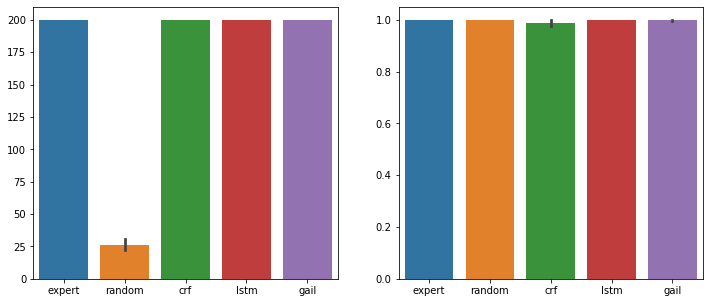

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.barplot(data=Rewards, ax=ax[0])
sns.barplot(data=ACC, ax=ax[1])

In [24]:

for column in ACC.columns:
    print('Confidence Interval for the mean accuracy of {}: {}'.format(column, mean_confidence_interval(ACC[column].to_numpy())))
    print('Confidence Interval for the mean reward of {}: {}'.format(column, mean_confidence_interval(Rewards[column].to_numpy())))

Confidence Interval for the mean accuracy of expert: (1.0, 0.0)
Confidence Interval for the mean reward of expert: (200.0, 0.0)
Confidence Interval for the mean accuracy of random: (1.0, 0.0)
Confidence Interval for the mean reward of random: (26.45, 5.258877075058519)
Confidence Interval for the mean accuracy of crf: (0.99, 0.012498332344661571)
Confidence Interval for the mean reward of crf: (200.0, 0.0)
Confidence Interval for the mean accuracy of lstm: (0.9992500000000002, 0.0008572796523491898)
Confidence Interval for the mean reward of lstm: (200.0, 0.0)
Confidence Interval for the mean accuracy of gail: (0.99825, 0.0013739567928923396)
Confidence Interval for the mean reward of gail: (200.0, 0.0)


In [25]:
t_tests(ACC)


T test for epxert vs crf: Ttest_indResult(statistic=-1.674642661668587, pvalue=0.11038590879409078)
T test for random vs crf: Ttest_indResult(statistic=-1.674642661668587, pvalue=0.11038590879409078)
T test for epxert vs lstm: Ttest_indResult(statistic=-1.831103813678747, pvalue=0.08281384258458341)
T test for random vs lstm: Ttest_indResult(statistic=-1.831103813678747, pvalue=0.08281384258458341)
T test for epxert vs gail: Ttest_indResult(statistic=-2.6658713826829414, pvalue=0.015271361252154836)
T test for random vs gail: Ttest_indResult(statistic=-2.6658713826829414, pvalue=0.015271361252154836)


In [26]:
t_tests(Rewards)

T test for epxert vs crf: Ttest_indResult(statistic=nan, pvalue=nan)
T test for random vs crf: Ttest_indResult(statistic=69.0726022795488, pvalue=2.7706587418067725e-24)
T test for epxert vs lstm: Ttest_indResult(statistic=nan, pvalue=nan)
T test for random vs lstm: Ttest_indResult(statistic=69.0726022795488, pvalue=2.7706587418067725e-24)
T test for epxert vs gail: Ttest_indResult(statistic=nan, pvalue=nan)
T test for random vs gail: Ttest_indResult(statistic=69.0726022795488, pvalue=2.7706587418067725e-24)


### Acrobot

In [27]:
Rewards = pd.DataFrame()
ACC = pd.DataFrame()

data, rewards, splits = acrobot_expert.generate_data(20)
ACC['expert'] = np.array([1 for i in range(20)])
Rewards['expert'] = rewards
data, rewards, splits = acrobot_expert.generate_data(20, adversary='random')
ACC['random'] = np.array([1 for i in range(20)])
Rewards['random'] = rewards

#### CRF

In [27]:
def feats(seq, k):
    
    return {
            'f11': np.format_float_positional(seq[k-1][0], 2, unique=False),
            'f12': np.format_float_positional(seq[k][0], 2, unique=False),
            'f21': np.format_float_positional(seq[k-1][1], 2, unique=False),
            'f22': np.format_float_positional(seq[k][1], 2, unique=False),
            'f31': np.format_float_positional(seq[k-1][2], 2, unique=False),
            'f32': np.format_float_positional(seq[k][2], 2, unique=False),
            'f41': np.format_float_positional(seq[k-1][3], 2, unique=False),
            'f42': np.format_float_positional(seq[k][3], 2, unique=False),
            'f51': np.format_float_positional(seq[k-1][4], 1, unique=False),
            'f52': np.format_float_positional(seq[k][4], 1, unique=False),
            'f61': np.format_float_positional(seq[k-1][5], 1, unique=False),
            'f62': np.format_float_positional(seq[k][5], 1, unique=False),
            'first': k == 0
            #'last': k == len(seq)-1
            #'bias': True
    }

def labs(seq, k):
    
    return str(seq[k][6])
    
def seq_to_feats(seq):
    
    return [feats(seq, k) for k in range(len(seq))]

def seq_to_labs(seq):
    
    return [labs(seq, k) for k in range(len(seq))]




crf = pickle.load(open('crf_models/non_adversarial/acrobot.pkl', 'rb'))

rewards = []

for j in range(20):
    sequence = np.empty((500, 6))
    sequence[0] = acrobot.reset()
    i = 0
    done = False
    score = 0
    while not done:
        
        i += 1
        features = seq_to_feats(sequence[0:i])
        #print(features)
        policy = int(float(crf.predict_single(features)[-1]))
        observation, reward, done, info = acrobot.step(policy)
        sequence[i] = observation
        score += reward
#         env.render()
#         time.sleep(0.01)
       
        
    
    rewards.append(score)
    
data, rewards, splits = acrobot_expert.generate_data(20)
X = [seq_to_feats(seq) for seq in np.split(data, splits)[0:-1]]
y = [seq_to_labs(seq) for seq in np.split(data, splits)[0:-1]]
preds = crf.predict(X)
acc = np.array([np.mean(np.array(pred) == np.array(act)) for pred, act in zip(preds, y)])

In [28]:
crf.num_attributes_

2687

In [29]:
Rewards['crf'] = rewards
ACC['crf'] = acc

#### LSTM

In [20]:
lstm = PolicyLSTM(8, 20, 3)
lstm.load_state_dict(torch.load('lstm_models/non_adversarial/acrobot.pt'), strict=False)


def seq_to_x(seq):
    
    return torch.tensor([
            [seq[i][0], seq[i][1], seq[i][2], seq[i][3], seq[i][4], seq[i][5],  int(i==0), 0] 
            for i in range(len(seq))
        ], dtype=torch.float).unsqueeze(0)

def seq_to_target(seq):
    
    return torch.tensor([
            seq[i][6] for i in range(len(seq))
        ], dtype=torch.long)


def test_X(data):
    
    return [
                seq_to_x(seq) for seq in data
            ]


def test_Y(data):
    
    return [
            seq_to_target(seq) for seq in data
        ]


rewards = []
for i in range(20):

    #print(i)
    observation = acrobot.reset()
    #print(observation)
    done = False
    rd = 0
    traj = torch.tensor([[1000, 1000, 1000, 1000, 1000, 1000, 0, 1] for i in range(400)], dtype=torch.float).unsqueeze(0)
    while not done:

        traj[0][-rd] = torch.tensor([ob for ob in observation] + [int(rd==0)] + [0])
        #print(traj.shape)
        action = lstm.predict(traj)
        #print(action, expert.policy(observation), -rd)
        observation, reward, done, _ = acrobot.step(int(action[-rd].item()))
        rd += int(reward)

    rewards.append(rd)

data, rewards, splits = acrobot_expert.generate_data(20)
X = test_X(np.split(data, splits)[0:-1])
y = test_Y(np.split(data, splits)[0:-1])
preds = [lstm.predict(x) for x in X]
acc = np.array([np.mean(np.array(pred) == np.array(act)) for pred, act in zip(preds, y)])

In [21]:
Rewards['lstm'] = rewards
ACC['lstm'] = acc

In [22]:
x = 0
for param in lstm.parameters():
    x += np.product([p for p in param.shape])
    
x

4923

### GAIL

In [32]:
acc = pickle.load(open('gail_acrobot_acc.pkl', 'rb'))
rewards = pickle.load(open('gail_acrobot_rewards.pkl', 'rb'))

Rewards['gail'] = rewards
ACC['gail'] = acc

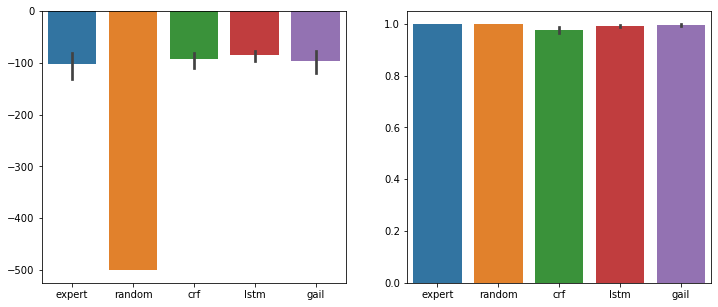

In [33]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
sns.barplot(data=Rewards, ax=ax[0])
sns.barplot(data=ACC, ax=ax[1])

In [34]:

for column in ACC.columns:
    print('Confidence Interval for the mean accuracy of {}: {}'.format(column, mean_confidence_interval(ACC[column].to_numpy())))
    print('Confidence Interval for the mean reward of {}: {}'.format(column, mean_confidence_interval(Rewards[column].to_numpy())))

Confidence Interval for the mean accuracy of expert: (1.0, 0.0)
Confidence Interval for the mean reward of expert: (-103.1, 27.534834784703165)
Confidence Interval for the mean accuracy of random: (1.0, 0.0)
Confidence Interval for the mean reward of random: (-500.0, 0.0)
Confidence Interval for the mean accuracy of crf: (0.9761890060039515, 0.013257827967811185)
Confidence Interval for the mean reward of crf: (-91.95, 16.693494105823888)
Confidence Interval for the mean accuracy of lstm: (0.9933389205109396, 0.0036018805237296343)
Confidence Interval for the mean reward of lstm: (-85.4, 10.349252355594336)
Confidence Interval for the mean accuracy of gail: (0.9957407581456199, 0.0031192022341038164)
Confidence Interval for the mean reward of gail: (-96.0, 23.64917326772286)


In [35]:
t_tests(ACC)


T test for epxert vs crf: Ttest_indResult(statistic=-3.7590609347247446, pvalue=0.0013282374726318472)
T test for random vs crf: Ttest_indResult(statistic=-3.7590609347247446, pvalue=0.0013282374726318472)
T test for epxert vs lstm: Ttest_indResult(statistic=-3.8707001820517193, pvalue=0.0010294415600916266)
T test for random vs lstm: Ttest_indResult(statistic=-3.8707001820517193, pvalue=0.0010294415600916266)
T test for epxert vs gail: Ttest_indResult(statistic=-2.8580050236214594, pvalue=0.010064361280623881)
T test for random vs gail: Ttest_indResult(statistic=-2.8580050236214594, pvalue=0.010064361280623881)


In [36]:
t_tests(Rewards)

T test for epxert vs crf: Ttest_indResult(statistic=0.7247583741068947, pvalue=0.4739829483252812)
T test for random vs crf: Ttest_indResult(statistic=51.16115655519564, pvalue=8.067218498969505e-22)
T test for epxert vs lstm: Ttest_indResult(statistic=1.2594201021790534, pvalue=0.21985977761635694)
T test for random vs lstm: Ttest_indResult(statistic=83.84835378843478, pvalue=7.047088179971143e-26)
T test for epxert vs gail: Ttest_indResult(statistic=0.40941656590151454, pvalue=0.6845848543961335)
T test for random vs gail: Ttest_indResult(statistic=35.75523374151159, pvalue=6.816924467378739e-19)


## Second Problem
### Imitation Learning with adversarial data

#### Generate adversarial data